# Plotting Memory Suppression Experiments on Top of Each Other

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Liberation Serif']
import os
from datetime import datetime
from core import Config
import pickle

In [ ]:
def plot_haystack_train_conv_mem_supress(only_beg, colors, fin_quartiles_ckpts, beg_quartiles_ckpts, x_values_list, valA, haystack_len, experiments, steps, nope, abs_err=False, datasource="val"):
    fig_sz_boost = 1.2
    marker_boost = 3
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(fig_sz_boost*7, fig_sz_boost*5))
    fig_len, ax_len = plt.subplots(1, 1, sharex=True, figsize=(fig_sz_boost*7.4, fig_sz_boost*4.8))

    #load the pseudo_pred_errs from a file
    if datasource == "backstory_train":
        added_str = "_"
    else:
        added_str = "_irrelevant_tokens_new_hay_insert_"
    with open(f"/data/shared/ICL_Kalman_Experiments/train_and_test_data/ortho_haar/{datasource}{added_str}pseudo_pred_errs_ortho_haar_ident_C_haystack_len_1.pkl", 'rb') as f:
        pseudo_pred_errs = pickle.load(f)
        print(f"Loaded pseudo_pred_errs from {f.name}, shape: {pseudo_pred_errs.shape}")

    beg_markers = ["x", "s", "<"]
    fin_markers = ["o", "D", ">"]

    #all marker types 

    early_stop_ind = None

    # if valA == "ortho":
    #     steps = [1,2,3,5,10]
    # else:
    #     steps = [1,2,3]

    if len(steps) > len(colors):
        # generate more colors from viridis colormap
        colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))

    print(f"\n\n in haystack train conv plot valA: {valA}, abs_err: {abs_err}\n\n")

    exp_count = 0
    first_x_val = 0
    first_qs = {}
    beg_first_qs = {}
    merge_ind = 22

    for fin_quartiles_ckpt, beg_quartiles_ckpt, x_values in zip(fin_quartiles_ckpts, beg_quartiles_ckpts, x_values_list):

        

        print(f"exp_count: {exp_count}, len of x_values: {len(x_values)}")

        if len(x_values) == 13:
            print(x_values)
        for key in fin_quartiles_ckpt.keys():
            if key == "MOP": #key == "OLS_analytical_ir_1" or key == "OLS_ir_1": #key == "MOP" or 
                col_count = 0
                for step in steps:
                    print(f"exp_count: {exp_count}")

                    key_lab = "TF" if key == "MOP" else key
                    qs = np.array(fin_quartiles_ckpt[key][step])
                    qs = np.transpose(qs)

                    if valA == "gaussA":
                        if not abs_err:
                            qs -= 1

                    # #if key contains OLS then repeat the values in qs to be the length of x_values
                    # if "OLS" in key:
                    #     print(f"key: {key} qs shape: {qs.shape}")
                    #     qs = np.repeat(qs, len(x_values), axis=0)
                    #     print(f"qs shape after repeat: {qs.shape}")

                    if step == 2:
                        #find the index of the minimum of qs[1]
                        early_stop_ind = np.argmin(qs[1])
                        print(f"early_stop_ind: {early_stop_ind}, x_values[early_stop_ind]: {x_values[early_stop_ind]}")

                        # raise NotImplementedError("Check the early stop index")

                    if exp_count > 0:
                        print(f"first_qs: {first_qs}")
                        print(f"qs before prepend: {qs.shape}, x_values before prepend: {x_values.shape}")
                        #prepend the x_values with the first x value
                        if step == steps[0]:
                            x_values = np.insert(x_values, 0, first_x_val)
                        #prepend the qs with the first qs
                        qs = np.insert(qs, 0, first_qs[step], axis=1)
                    
                    if not only_beg:
                        ax.plot(x_values, qs[1], label=f"{step} after fin.: {experiments[exp_count]}", markersize=marker_boost*2, marker=fin_markers[exp_count], zorder=5 if key == "MOP" else 0, color=colors[col_count], linewidth=2)
                        # if not valA == "gaussA":
                        #     ax.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])

                        ax.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])

                        ax_len.plot(x_values, qs[1], label=f"{step} after fin.: {experiments[exp_count]}", markersize=marker_boost*2, marker=fin_markers[exp_count], zorder=5 if key == "MOP" else 0, color=colors[col_count], linewidth=2)
                        ax_len.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])
                        print(f"qs shape: {qs.shape}, x_values shape: {x_values.shape}, step: {step}, key: {key}")



                        color = ax.get_lines()[-1].get_color()

                    else:
                        color = colors[col_count]

                    beg_qs = np.array(beg_quartiles_ckpt[key][step])
                    beg_qs = np.transpose(beg_qs)

                    if exp_count > 0:
                        beg_qs = np.insert(beg_qs, 0, beg_first_qs[step], axis=1)
                        print(f"qs after prepend: {qs.shape}, x_values after prepend: {x_values.shape}, beg_qs after prepend: {beg_qs.shape}")
                    #set the color to the same as the fin quartiles
                    ax.plot(x_values, beg_qs[1], label=f"{step} after init.: {experiments[exp_count]}", markersize=1 if "OLS" in key_lab else marker_boost*2, marker=beg_markers[exp_count], color=color, linestyle="-" if "OLS_ir" in key_lab else (":" if "OLS_analytical" in key_lab else "--"), linewidth=5 if "OLS_analytical" in key_lab else 2, zorder=2)

                    # if not valA == "gaussA":
                    #     ax.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)
                    ax.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.1, color=color, zorder=1)

                    ax_len.plot(x_values, beg_qs[1], label=f"{step} after init.: {experiments[exp_count]}", markersize=1 if "OLS" in key_lab else marker_boost*2, marker=beg_markers[exp_count], color=color, linestyle="-" if "OLS_ir" in key_lab else (":" if "OLS_analytical" in key_lab else "--"), linewidth=5 if "OLS_analytical" in key_lab else 2)
                    ax_len.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.1, color=color)

                    if exp_count == 0:
                            print(f"step: {step}")
                            print(f"first x_values: {x_values[-merge_ind]}")
                            print(f"first qs: {qs[:,-merge_ind]}")
                            first_x_val = x_values[-merge_ind]
                            first_qs[step] = qs[:,-merge_ind]
                            beg_first_qs[step] = beg_qs[:,-merge_ind]



                    #plot the pseudo prediction errors
                    #take the median of the pseudo prediction errors
                    pseudo_pred_meds = np.median(pseudo_pred_errs, axis=1)
                    print(f"pseudo_pred_meds[0,2]: {pseudo_pred_meds[0,2]}")
                    print(f"shape of pseudo_pred_meds: {pseudo_pred_meds.shape}")
                    pseudo_pred_qs = np.quantile(pseudo_pred_meds, [0.25, 0.5, 0.75], axis=0)
                    print(f"shape of pseudo_pred_qs: {pseudo_pred_qs.shape}")
                    print(f"value of index 1 + step: {1 + step}")

                    skip = 5
                    y = np.full(x_values[::skip].shape, pseudo_pred_qs[1, 1 + step], dtype=float)
                    yerr_lower = np.full(x_values[::skip].shape, pseudo_pred_qs[1, 1 + step] - pseudo_pred_qs[0, 1 + step], dtype=float)
                    yerr_upper = np.full(x_values[::skip].shape, pseudo_pred_qs[2, 1 + step] - pseudo_pred_qs[1, 1 + step], dtype=float)

                    if exp_count == 0 and step < 7:
                        dither = (2*(step % 2) - 1)
                        dith_len = len(x_values[::skip])
                        #linspace from 0 to 1 with dith_len points
                        dither_list = dither*np.linspace(0, 1, dith_len)*1e5
                        ax.errorbar(
                            x_values[::skip] + dither_list, y,
                            yerr=[yerr_lower, yerr_upper],
                            fmt='o', color=colors[col_count],
                            label=f"{step} after init.: pseudoinv.", capsize=5, markersize=2, marker=".", linestyle=":", linewidth=2, zorder=100
                        )
                        ax_len.errorbar(
                            x_values[::skip] + dither_list, y,
                            yerr=[yerr_lower, yerr_upper],
                            fmt='o', color=colors[col_count],
                            label=f"{step} after init.: pseudoinv.", capsize=5, markersize=2, marker=".", linestyle=":", linewidth=2, zorder=100
                    )

                    col_count += 1
        exp_count += 1

    # #plot a vertical dashed line at first_x_val
    # ax.axvline(x=first_x_val, color='black', linestyle='--', linewidth=2, label="Restart checkpoint", zorder=100)
    # ax_len.axvline(x=first_x_val, color='black', linestyle='--', linewidth=2, label="Restart checkpoint", zorder=100)



    ax.set_xlabel("# of Training Examples", fontsize=14)
    ax.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" and not abs_err else ""), fontsize=14)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, which="major", linestyle='-', linewidth=0.5, alpha=0.25)
    ax.grid(True, which="minor", linestyle=':', linewidth=0.5, alpha=0.2)
    # ax.legend(fontsize=8, bbox_to_anchor=(1.05, 1))
    leg = fig.legend(fontsize=10, loc="outside lower left", ncol=2, bbox_to_anchor=(0.08, 0.1))
    #set zorder of legend to 0
    leg.set_zorder(0)
    #set alpha of legend to 0.8
    leg.get_frame().set_alpha(0.7)

    # ax.set_xlim(639000, 78081000)
    # ax.set_xlim(639000, 1.2e8)
    ax.set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)
    # print(f"xlim: {ax.get_xlim()}")
    # ax.set_ylim([5e-2, 3e0])
    # ax.set_title(("Ortho" if valA == "ortho" else ("Gaussian" if valA == "gaussA" else "Identity")) + f" Haystack Length: {haystack_len} vs Training Examples")
    ax.set_ylim([1e-3, 1.5])

    ax_len.set_xlabel("# of Training Examples", fontsize=14)
    ax_len.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" and not abs_err else ""), fontsize=14)
    ax_len.set_yscale('linear')
    ax_len.set_xscale('log')
    ax_len.grid(True, which="major", linestyle='-', linewidth=0.5, alpha=0.25)
    ax_len.grid(True, which="minor", linestyle=':', linewidth=0.5, alpha=0.2)
    # ax_len.legend(fontsize=8) #"center right" if valA == "ident" else 
    # fig_len.legend(fontsize=10, loc="outside", ncol=1)#, bbox_to_anchor=(0.1, 0.1))
    ax_len.legend(fontsize=11, loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0, ncol=1)
    # fig_len.legend(fontsize=10, loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=8)
    ax_len.set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)
    # ax_len.set_xlim(639000, 78081000)
    # ax_len.set_xlim(639000, 1.2e8)
    ax_len.set_ylim([-1e-3, 1.5])


    #add the date and time to the filename
    now = datetime.now()
    timestamp = now.strftime("%Y%m%d_%H%M%S")


    figure_dir = f"../outputs/mem_suppress_conglomerate/" 
    os.makedirs(figure_dir, exist_ok=True)

    fig.tight_layout()
    fig_len.tight_layout()
    
    adj = "orig_"
    fig.savefig(figure_dir + (f"{datasource}_" if datasource != "val" else "") + ("init_" if only_beg else "") + f"mem_suppress_{adj}{valA}_embd_dim_192_train_conv_haystack_len_{haystack_len}_{timestamp}_logscale.pdf", transparent=True, format="pdf")
    
    fig_len.savefig(figure_dir + (f"{datasource}_" if datasource != "val" else "") + ("init_" if only_beg else "") + f"mem_suppress_{adj}{valA}_embd_dim_192_train_conv_haystack_len_{haystack_len}_{timestamp}_linearscale.pdf", transparent=True, format="pdf")

    plt.show()
    return early_stop_ind

In [ ]:
only_beg = True
datasource="train" #"backstory_train" # "train" or "val"
colors=['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']

experiment_names = ["250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000"]#, "backstory_masked_250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000", "backstory_unmasked_250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000"]

# experiment_names = ["backstory_masked_250612_122321.8e31cc_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000"]

# from beg
# "backstory_masked_250612_122321.8e31cc_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000", "backstory_unmasked_250624_161505.8090a8_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000"]

# experiment_names = ["backstory_masked_250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000", "backstory_unmasked_250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000"]

out_path = "/home/sultand/interleaved_time_series/TFs_do_KF_ICL/outputs/GPT2/"

hay_len = 1

train_conv_beg_quartiles_files = []
train_conv_fin_quartiles_files = []
x_values_files = []
for experiment_name in experiment_names:
    fpath = f"/needles/train_conv/" + (f"{datasource}_" if datasource != "val" else "")+ "train_conv"
    train_conv_beg_quartiles_files.append(f"{out_path}{experiment_name}{fpath}_beg_quartiles_haystack_len_{hay_len}.pkl")
    train_conv_fin_quartiles_files.append(f"{out_path}{experiment_name}{fpath}_fin_quartiles_haystack_len_{hay_len}.pkl")
    x_values_files.append(f"{out_path}{experiment_name}/needles/train_conv/" + (f"{datasource}_" if datasource != "val" else "")+ f"x_values_haystack_len_{hay_len}.npy")

# datasources = ["train", "backstory_train", "val"]
# # datasources = ["first_500_train", "train"]
# experiment_name = experiment_names[-1]
# for datasource in datasources:
#     fpath = f"/needles/train_conv/" + (f"{datasource}_" if datasource != "val" else "") + "train_conv"
#     train_conv_beg_quartiles_files.append(f"{out_path}{experiment_name}{fpath}_beg_quartiles_haystack_len_{hay_len}.pkl")
#     train_conv_fin_quartiles_files.append(f"{out_path}{experiment_name}{fpath}_fin_quartiles_haystack_len_{hay_len}.pkl")
#     x_values_files.append(f"{out_path}{experiment_name}/needles/train_conv/x_values_haystack_len_{hay_len}.npy")

beg_quartiles_ckpts = []
fin_quartiles_ckpts = []
x_values_list = []
for train_conv_beg_quartiles_file, train_conv_fin_quartiles_file, x_values_file in zip(train_conv_beg_quartiles_files, train_conv_fin_quartiles_files, x_values_files):
    print(f"Loading files for {train_conv_beg_quartiles_file}, {train_conv_fin_quartiles_file}, {x_values_file}")
    if os.path.exists(train_conv_beg_quartiles_file):
        print(f"Loading train conv beg quartiles from {train_conv_beg_quartiles_file}")
        with open(train_conv_beg_quartiles_file, "rb") as f:
            beg_quartiles_ckpt = pickle.load(f)
            beg_quartiles_ckpts.append(beg_quartiles_ckpt)

    if os.path.exists(train_conv_fin_quartiles_file):
        print(f"Loading train conv fin quartiles from {train_conv_fin_quartiles_file}")
        with open(train_conv_fin_quartiles_file, "rb") as f:
            fin_quartiles_ckpt = pickle.load(f)
            fin_quartiles_ckpts.append(fin_quartiles_ckpt)

    if os.path.exists(x_values_file):
        print(f"Loading x values from {x_values_file}")
        x_values = np.load(x_values_file)
        print(len(x_values))
        x_values_list.append(x_values)

    



Loading files for /home/sultand/TFs_do_KF_ICL/outputs/GPT2/250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/train_train_conv_beg_quartiles_haystack_len_1.pkl, /home/sultand/TFs_do_KF_ICL/outputs/GPT2/250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/train_train_conv_fin_quartiles_haystack_len_1.pkl, /home/sultand/TFs_do_KF_ICL/outputs/GPT2/250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/train_x_values_haystack_len_1.npy
Loading train conv beg quartiles from /home/sultand/TFs_do_KF_ICL/outputs/GPT2/250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/train_train_conv_beg_quartiles_haystack_len_1.pkl
Loading train conv fin quartiles from /home/sultand/TFs_do_KF_

Loaded pseudo_pred_errs from /data/shared/ICL_Kalman_Experiments/train_and_test_data/ortho_haar/train_irrelevant_tokens_new_hay_insert_pseudo_pred_errs_ortho_haar_ident_C_haystack_len_1.pkl, shape: (39975, 1, 25)


 in haystack train conv plot valA: ortho_haar, abs_err: False


exp_count: 0, len of x_values: 38
exp_count: 0
step: 1
first x_values: 19840000
first qs: [0.01942153 0.03575613 0.05680531]
pseudo_pred_meds[0,2]: 0.4794926941394806
shape of pseudo_pred_meds: (39975, 25)
shape of pseudo_pred_qs: (3, 25)
value of index 1 + step: 2
exp_count: 0
early_stop_ind: 37, x_values[early_stop_ind]: 78080000
step: 2
first x_values: 19840000
first qs: [0.00439051 0.00831877 0.01638974]
pseudo_pred_meds[0,2]: 0.4794926941394806
shape of pseudo_pred_meds: (39975, 25)
shape of pseudo_pred_qs: (3, 25)
value of index 1 + step: 3
exp_count: 0
step: 3
first x_values: 19840000
first qs: [0.00397628 0.00758893 0.01568119]
pseudo_pred_meds[0,2]: 0.4794926941394806
shape of pseudo_pred_meds: (39975, 

/tmp/ipykernel_607726/147547174.py:147: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/tmp/ipykernel_607726/147547174.py:153: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax_len.errorbar(


step: 7
first x_values: 19840000
first qs: [0.00182723 0.00387863 0.0075331 ]
pseudo_pred_meds[0,2]: 0.4794926941394806
shape of pseudo_pred_meds: (39975, 25)
shape of pseudo_pred_qs: (3, 25)
value of index 1 + step: 8
exp_count: 0
step: 8
first x_values: 19840000
first qs: [0.00158788 0.0036911  0.00682582]
pseudo_pred_meds[0,2]: 0.4794926941394806
shape of pseudo_pred_meds: (39975, 25)
shape of pseudo_pred_qs: (3, 25)
value of index 1 + step: 9


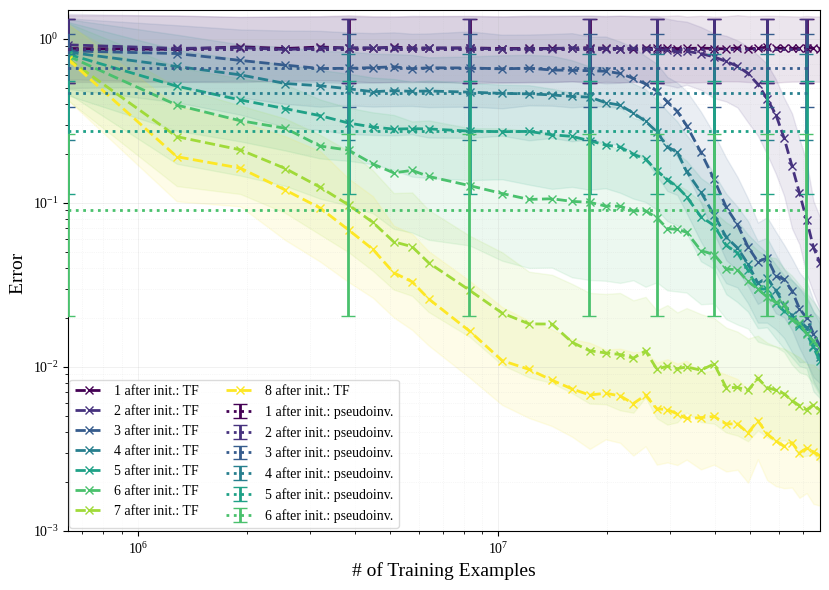

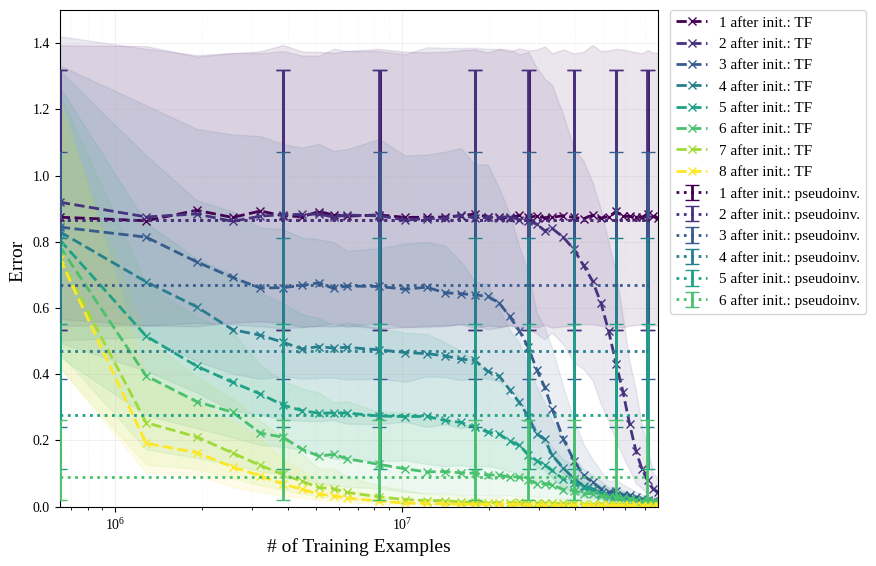

np.int64(37)

In [9]:
steps_in = list(range(1, 9))
# steps_in = [1,2,3,5]
# fin_quartiles_ckpts = [fin_quartiles_ckpts[0]]
# beg_quartiles_ckpts = [beg_quartiles_ckpts[0]]
# x_values_list = [x_values_list[0]]
plot_haystack_train_conv_mem_supress(only_beg, colors, fin_quartiles_ckpts, beg_quartiles_ckpts, x_values_list, "ortho_haar", hay_len, ["TF", "masked backst.", "unmasked backst."], steps=steps_in, nope=False, abs_err=False, datasource=datasource)